In [1]:
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import GlobalAveragePooling2D
from keras.models import Model
from keras import preprocessing, Input
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, Conv1D
from tensorflow.keras.layers import Add, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report


In [2]:


# Load your label data
label_csv = r"c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\Dataset\labels.csv"
data = pd.read_csv(label_csv)

print("Total data shape:", data.shape)
data.head()


Total data shape: (6992, 5)


,Unnamed: 0,image_name,text_ocr,text_corrected,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,neutral


In [3]:
import os
import numpy as np
from PIL import Image

image_folder = r"c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\Dataset\images\images"

def load_image(path):
    try:
        with Image.open(path) as img:
            img = img.convert('RGB')
            img = img.resize((224, 224))
            return np.array(img)
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None

# Add image path
data["image_path"] = data["image_name"].apply(lambda x: os.path.join(image_folder, x))
data["file_exists"] = data["image_path"].apply(os.path.exists)

# Keep only existing images
data = data[data["file_exists"] == True]

# Load images
data["image_array"] = data["image_path"].apply(load_image)

# Drop rows where image failed to load
data = data.dropna(subset=["image_array"])

print("Data shape after image loading:", data.shape)


Failed to load c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\Dataset\images\images\image_5119.png: image file is truncated


c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\.venv\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Data shape after image loading: (6991, 8)


In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['enc_label'] = label_encoder.fit_transform(data['overall_sentiment'])

print("Encoded Labels Mapping:")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Encoded Labels Mapping:
{'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2), 'very_negative': np.int64(3), 'very_positive': np.int64(4)}


In [5]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['enc_label'])

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)


Train shape: (5592, 9)
Test shape: (1399, 9)


In [6]:
from sklearn.utils.class_weight import compute_class_weight

y = train_data['enc_label']
classes = np.unique(y)

weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
weight = dict(zip(classes, weights))
print("Class Weights:", weight)


Class Weights: {np.int64(0): np.float64(2.9125), np.int64(1): np.float64(0.6350936967632027), np.int64(2): np.float64(0.44736), np.int64(3): np.float64(9.24297520661157), np.int64(4): np.float64(1.353995157384988)}


In [8]:

from tensorflow.keras.layers import Dense

def build_model():
    # Load ResNet50 without top layer
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    output = Dense(5, activation='softmax')(x)  # 5 classes

    model = Model(inputs=base_model.input, outputs=output)
    return model

model = build_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:

# Convert to numpy arrays
X_train = np.stack(train_data['image_array'].values)
y_train = train_data['enc_label'].values

X_test = np.stack(test_data['image_array'].values)
y_test = test_data['enc_label'].values

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (5592, 224, 224, 3) (5592,)
Test shape: (1399, 224, 224, 3) (1399,)


In [11]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])


In [12]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    class_weight=weight,
                    verbose=1)


Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 118s 714ms/step - accuracy: 0.2347 - loss: 2.1897 - val_accuracy: 0.2036 - val_loss: 1.8191
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 111s 705ms/step - accuracy: 0.2111 - loss: 2.0690 - val_accuracy: 0.2696 - val_loss: 1.6723
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 118s 744ms/step - accuracy: 0.2243 - loss: 1.9510 - val_accuracy: 0.2357 - val_loss: 1.7297
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 102s 648ms/step - accuracy: 0.2482 - loss: 1.7980 - val_accuracy: 0.2554 - val_loss: 1.6434
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 98s 617ms/step - accuracy: 0.2282 - loss: 1.8148 - val_accuracy: 0.2589 - val_loss: 1.6343
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 99s 624ms/step - accuracy: 0.2396 - loss: 1.7901 - val_accuracy: 0.2750 - val_loss: 1.6019
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 99s 627ms/step - accuracy: 0.2418 - loss: 1.7790 - val_accuracy: 0.2589 - val_loss: 1.6103
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 97s 616ms/step - accuracy: 0.2489 - los

In [14]:
!pip install matplotlib


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 621.2 kB/s eta 0:00:13
   -- ------------------------------------- 0.5/8.1 MB 621.2 kB/s eta 0:00:13
   --- ------------------------------------ 0.8/8.1 MB 633.2 kB/s eta 0:00:12
   ----- ---------------------------------- 1.0/8.1 MB 662.0 kB/s eta 0:00:11
   ----- ---------------------------------- 1.0/8.1 MB 662.0 kB/s eta 0:00:11
   ------ --------------------------------- 1.3/8.1 MB 664.5 kB/s eta 0:00:11
   ------ --------------------------------- 1.3/8

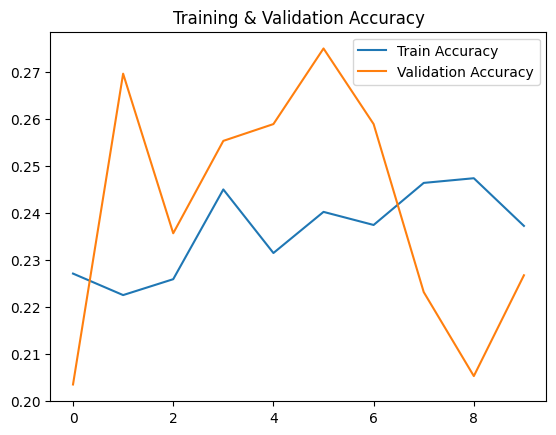

44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 735ms/step - accuracy: 0.2413 - loss: 1.6450
Test Accuracy: 0.2380


In [15]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")


In [16]:


# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 751ms/step
Classification Report:
               precision    recall  f1-score   support

     negative       0.08      0.08      0.08        96
      neutral       0.34      0.31      0.32       440
     positive       0.50      0.19      0.28       626
very_negative       0.03      0.33      0.06        30
very_positive       0.17      0.29      0.21       207

     accuracy                           0.24      1399
    macro avg       0.23      0.24      0.19      1399
 weighted avg       0.36      0.24      0.26      1399

Confusion Matrix:
[[  8  28  18  20  22]
 [ 29 136  66 110  99]
 [ 50 160 120 140 156]
 [  1   5   6  10   8]
 [  8  70  28  42  59]]


In [17]:
# Unfreeze last 50 layers of ResNet
for layer in model.layers[-50:]:
    if not isinstance(layer, Dense):  # Do not unfreeze final Dense layer
        layer.trainable = True

print("Total trainable layers:", len([l for l in model.layers if l.trainable]))


Total trainable layers: 50


In [19]:

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-5),  # Lower LR
              metrics=['accuracy'])


In [20]:
history_finetune = model.fit(X_train, y_train,
                             epochs=5,
                             batch_size=32,
                             validation_split=0.1,
                             class_weight=weight,
                             verbose=1)


Epoch 1/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 156s 937ms/step - accuracy: 0.3219 - loss: 1.7986 - val_accuracy: 0.1875 - val_loss: 1.7160
Epoch 2/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 148s 940ms/step - accuracy: 0.3101 - loss: 1.4110 - val_accuracy: 0.2571 - val_loss: 1.5597
Epoch 3/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 143s 906ms/step - accuracy: 0.3587 - loss: 1.2229 - val_accuracy: 0.2732 - val_loss: 1.5341
Epoch 4/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 144s 910ms/step - accuracy: 0.4098 - loss: 1.0760 - val_accuracy: 0.2696 - val_loss: 1.5326
Epoch 5/5
158/158 ━━━━━━━━━━━━━━━━━━━━ 155s 979ms/step - accuracy: 0.4646 - loss: 0.9575 - val_accuracy: 0.2911 - val_loss: 1.4976


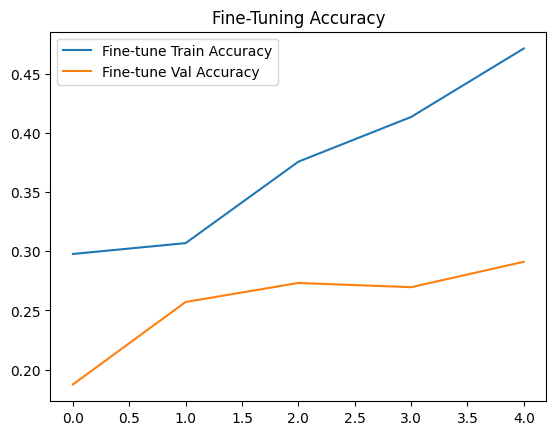

44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 572ms/step - accuracy: 0.3002 - loss: 1.5227
Test Accuracy after fine-tuning: 0.2924


In [21]:
import matplotlib.pyplot as plt

plt.plot(history_finetune.history['accuracy'], label='Fine-tune Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Fine-tune Val Accuracy')
plt.legend()
plt.title('Fine-Tuning Accuracy')
plt.show()

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy after fine-tuning: {test_acc:.4f}")


In [22]:
# Save model
model.save('resnet_sentiment_model.h5')
print("Model saved successfully!")

# If you want to load later
# from tensorflow.keras.models import load_model
# model = load_model('resnet_sentiment_model.h5')


Model saved successfully!


In [23]:

from tensorflow.keras.layers import Flatten

def build_cnn_model():
    cnn = Sequential()
    cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(64, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D((2, 2)))
    cnn.add(Flatten())
    cnn.add(Dense(256, activation='relu'))
    cnn.add(Dropout(0.3))
    return cnn

cnn_model = build_cnn_model()
cnn_model.summary()


c:\Users\Urvi\Documents\sem2\nlp\nlp_ven\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,672 (84.86 MB)

 Trainable params: 22,244,672 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:

from tensorflow.keras.layers import Concatenate


# Load ResNet without top layer
resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
resnet_base.trainable = False  # Keep frozen

# Inputs
resnet_input = Input(shape=(224, 224, 3))
cnn_input = Input(shape=(224, 224, 3))

# Feature Extraction
resnet_features = resnet_base(resnet_input)
resnet_features = GlobalAveragePooling2D()(resnet_features)

cnn_features = cnn_model(cnn_input)

# Late Fusion (Concatenation)
from tensorflow.keras.layers import Dense, Dropout

combined = Concatenate()([resnet_features, cnn_features])

# Classification Head
x = Dense(256, activation='relu')(combined)
x = Dropout(0.3)(x)
output = Dense(5, activation='softmax')(x)

# Fusion Model
fusion_model = Model(inputs=[resnet_input, cnn_input], outputs=output)
fusion_model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_4[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 256)       │ 22,244,672 │ input_layer_5[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2304)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    590,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │      1,285 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,423,749 (177.09 MB)

 Trainable params: 22,836,037 (87.11 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [25]:

fusion_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=Adam(learning_rate=1e-4),
                     metrics=['accuracy'])


In [26]:
# Multi-Input Format
X_train_multi = [X_train, X_train]
X_test_multi = [X_test, X_test]

history_fusion = fusion_model.fit(X_train_multi, y_train,
                                  epochs=10,
                                  batch_size=32,
                                  validation_split=0.1,
                                  class_weight=weight,
                                  verbose=1)


Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 150s 920ms/step - accuracy: 0.2047 - loss: 13.5007 - val_accuracy: 0.1929 - val_loss: 1.6700
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 140s 887ms/step - accuracy: 0.2145 - loss: 1.6491 - val_accuracy: 0.1804 - val_loss: 1.5921
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 141s 890ms/step - accuracy: 0.2396 - loss: 1.5314 - val_accuracy: 0.1768 - val_loss: 1.6174
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 141s 893ms/step - accuracy: 0.2911 - loss: 1.4853 - val_accuracy: 0.2232 - val_loss: 1.5783
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 145s 916ms/step - accuracy: 0.3102 - loss: 1.4205 - val_accuracy: 0.2929 - val_loss: 1.5293
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 143s 903ms/step - accuracy: 0.3637 - loss: 1.2935 - val_accuracy: 0.2018 - val_loss: 1.6298
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 144s 909ms/step - accuracy: 0.3579 - loss: 1.2681 - val_accuracy: 0.2018 - val_loss: 1.5972
Epoch 8/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 147s 930ms/step - accuracy: 0.4056 

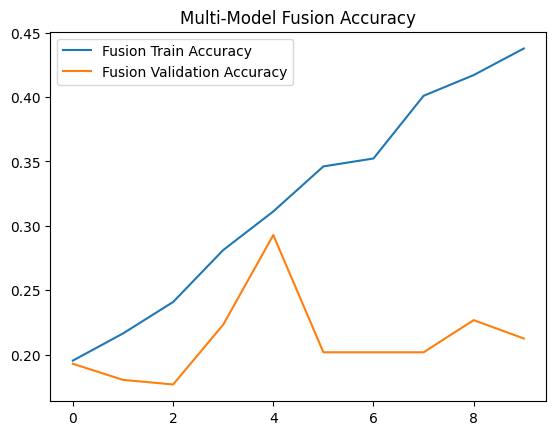

44/44 ━━━━━━━━━━━━━━━━━━━━ 35s 782ms/step - accuracy: 0.2214 - loss: 1.5927
Fusion Model Test Accuracy: 0.2266


In [27]:

# Plot
plt.plot(history_fusion.history['accuracy'], label='Fusion Train Accuracy')
plt.plot(history_fusion.history['val_accuracy'], label='Fusion Validation Accuracy')
plt.legend()
plt.title('Multi-Model Fusion Accuracy')
plt.show()

# Evaluate
test_loss, test_acc = fusion_model.evaluate([X_test, X_test], y_test, verbose=1)
print(f"Fusion Model Test Accuracy: {test_acc:.4f}")


In [28]:

# Predictions
y_pred = fusion_model.predict([X_test, X_test])
y_pred_classes = np.argmax(y_pred, axis=1)

# Report
print("Classification Report:\n", classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", cm)


44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 817ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.07      0.12      0.09        96
           1       0.33      0.22      0.27       440
           2       0.46      0.23      0.31       626
           3       0.04      0.23      0.07        30
           4       0.12      0.26      0.17       207

    accuracy                           0.23      1399
   macro avg       0.20      0.21      0.18      1399
weighted avg       0.33      0.23      0.26      1399

Confusion Matrix:
 [[ 12  22  20  13  29]
 [ 53  98  95  51 143]
 [ 75 124 147  83 197]
 [  4   4   7   7   8]
 [ 25  49  50  30  53]]
